Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [13]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time

In [2]:
%run FeedingData.ipynb
# read Calvin's function files so we can call those functions from this notebook
# list of functions: 
# mfcc_(song, n=20)
# mfcc_cut(song, n=20, cutoff = 800)
# LFCC(song, n=20)
# LFCC_no_low(song, n=20, cutoff = 800)
# LFCC_no_low_clean(song, n=20, cutoff = 800)
# mfcc_cut_cleaned(song, n=20, cutoff = 800)
# main_freq(song, cutoff = 800)

In [3]:
def get_data(audio_path, meta_file, load_length, get_feature_function):
    songs_matrix = []
    songs_id = []
    df = pd.read_csv(meta_file)
    id_list = df.cat_num

    for name in id_list:
        filepath = os.path.join(audio_path, str(name)+'.wav')
        # skipping files that are less than 250 ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # make sure that the size of the feature matrix is the same for all files
        song, sr = librosa.load(filepath, duration=load_length)
        features = get_feature_function(song, n = 40)
        songs_matrix.append(features)
        songs_id.append(name)
    return np.array(songs_matrix), songs_id

In [4]:
def get_labels(numbers, meta_file, label_name):
    # take in list of data id numbers and output their labels in label_name calssification
    df = pd.read_csv(meta_file)
    labels = []
    for num in numbers:
        labels.append(df[label_name].loc[df.cat_num == float(num)].item())
    return np.array(labels)

In [5]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table, append as value the corresponding label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_division])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_division][idx]
    return [lookup_table[label] for label in labels]

In [6]:
def remove_small_class(songs_matrix, songs_label, threshold):
    df_class = pd.DataFrame(np.unique(songs_label, return_counts=True)).T
    print('Data read:\n', df_class)
    # remove classes with too few data points
    small_class_list = []
    for row in range(len(df_class)):
        if df_class[1].iloc[row] < threshold:
            small_class_list.append(df_class[0].iloc[row].item())
    print('Removing classes:\n',small_class_list)
    delete_list = []
    for small_class in small_class_list:
        delete_list += list(np.where(songs_label==small_class)[0])

    short_label = np.delete(songs_label, delete_list)
    short_matrix = np.delete(songs_matrix, delete_list, 0)
    # double check data after deleting
    print('Reduced data:\n', pd.DataFrame(np.unique(short_label, return_counts=True)).T)
    return short_matrix, short_label

In [7]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Final_Train.csv'

start = time.time()
max_time = 5 # cut off time for loading, in sec
get_feature_function = mfcc_cut_cleaned
songs_matrix, songs_id = get_data(audio_path, meta_file, max_time, get_feature_function)
songs_label_critter = get_labels(songs_id, meta_file, 'critter_name')
songs_label_fam = get_labels(songs_id, meta_file, 'fam_or_subfam')
end = time.time()
print('time loading:', end - start)

time loading: 304.03171944618225


In [35]:
remove_small_class(songs_matrix, songs_label_fam, 1)

Data read:
                    0     1
0          Cicadidae    43
1     Conocephalinae   657
2       Eneopterinae    25
3          Gryllinae  1117
4     Gryllotalpidae    33
5         Hapithinae   297
6   Listroscelidinae     8
7      Mogoplistinae   269
8         Nemobiinae   299
9        Oecanthinae   579
10    Phalangopsidae    10
11   Phaneropterinae   427
12   Pseudophyllinae   110
13     Tettigoniinae   206
14     Trigonidiinae   435
Removing classes:
 []
Reduced data:
                    0     1
0          Cicadidae    43
1     Conocephalinae   657
2       Eneopterinae    25
3          Gryllinae  1117
4     Gryllotalpidae    33
5         Hapithinae   297
6   Listroscelidinae     8
7      Mogoplistinae   269
8         Nemobiinae   299
9        Oecanthinae   579
10    Phalangopsidae    10
11   Phaneropterinae   427
12   Pseudophyllinae   110
13     Tettigoniinae   206
14     Trigonidiinae   435


(array([[[-3.59213562e+02, -1.92298859e+02, -3.35712891e+01, ...,
           3.58978200e+00,  4.53807335e+01,  1.06942108e+02],
         [ 7.23509674e+01, -8.45796490e+00, -1.09461737e+01, ...,
          -1.44315338e+01,  2.93389244e+01,  8.45843048e+01],
         [ 5.71921349e+01, -3.50582862e+00, -8.86510086e+00, ...,
           6.86094093e+00,  8.87910175e+00,  4.66737688e-01],
         ...,
         [ 1.25346828e+00, -4.54836035e+00, -1.38514853e+00, ...,
           5.76841259e+00,  5.00658131e+00,  6.97490788e+00],
         [ 3.22317934e+00, -9.15467739e-01, -5.75874901e+00, ...,
           2.44885325e+00,  2.27636027e+00, -1.12792683e+00],
         [-1.48769987e+00,  5.20544291e-01,  2.72642875e+00, ...,
          -2.63961196e+00, -6.37924552e-01,  1.10840428e+00]],
 
        [[-5.26963997e+01, -5.26963997e+01, -5.26963997e+01, ...,
           4.48670530e+00,  4.68755007e+00, -2.96790552e+00],
         [ 1.18776888e-01,  1.18776888e-01,  1.18776888e-01, ...,
          -6.96722698

In [8]:
np.save('E:\chirpfiles\\songs_matrix_mfcc_cut_cleaned_5sec.npy', songs_matrix)
np.save('E:\chirpfiles\\songs_label_critter_5sec.npy', songs_label_critter)
np.save('E:\chirpfiles\\songs_label_fam_5sec.npy', songs_label_fam)
np.save('E:\chirpfiles\\songs_id_5sec.npy', songs_id)

In [11]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(songs_label_fam)
songs_label_onehot = to_categorical(songs_label_num) # required output format by cnn

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = songs_matrix
data_label = songs_label_onehot

# after 5/30, we are using already splitted data so this is already train and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_matrix, data_label, 
                                                  test_size = .2, random_state = 17)
# to use 2d convolution, keras model expects 4d input shape
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
#print('Train test split train shape: ', X_train.shape)

#X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 17)
#print('Train validation split train shape: ', X_tt.shape)

In [20]:
# make model 
input_shape =  (X_train.shape[1], X_train.shape[2],1,) # first dimension of train data is n_datapoints
model_mfcc_c_c_fam = Sequential([
    Input(input_shape),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(le.classes_), activation='softmax')
]) 

model_mfcc_c_c_fam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [21]:
# train model
start = time.time()
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_mfcc_c_c_fam.fit(X_train, y_train, epochs=epochs, batch_size=64, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint_callback])
end = time.time()
print('time training: ', end - start)
#predicted_vector = model.predict(X_test)
#predicted_class_index = np.argmax(predicted_vector, axis=-1)
#le.inverse_transform(predicted_class_index)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 637ms/step - accuracy: 0.2116 - loss: 8.1240 - val_accuracy: 0.4109 - val_loss: 1.9207
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 645ms/step - accuracy: 0.3941 - loss: 1.8928 - val_accuracy: 0.4806 - val_loss: 1.6689
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 634ms/step - accuracy: 0.5059 - loss: 1.5372 - val_accuracy: 0.5327 - val_loss: 1.5117
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 632ms/step - accuracy: 0.5693 - loss: 1.3640 - val_accuracy: 0.5537 - val_loss: 1.4253
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - accuracy: 0.6188 - loss: 1.2045 - val_accuracy: 0.5471 - val_loss: 1.4798
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 632ms/step - accuracy: 0.6498 - loss: 1.1017 - val_accuracy: 0.5637 - val_loss: 1.4358
time training:  235.0208740234375


In [24]:
early_stopping.stopped_epoch

5

In [29]:
import pickle

with open('hist_mfcc_c_c_twohiddenlayer_64_128_5sec_fam.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(history, f)

# Getting back the objects:
#with open('hist_batch64_onehiddenlayer_5sec_critter.pkl') as f:  # Python 3: open(..., 'rb')
#    obj0, obj1, obj2 = pickle.load(f)

In [26]:
print(history_dict)

{'accuracy': [0.26744186878204346, 0.4210963547229767, 0.5071982145309448, 0.5564783811569214, 0.6057586073875427, 0.6428571343421936], 'loss': [4.129305839538574, 1.8207032680511475, 1.5393462181091309, 1.3819838762283325, 1.2133958339691162, 1.0987510681152344], 'val_accuracy': [0.41085270047187805, 0.4806201457977295, 0.5326688885688782, 0.553709864616394, 0.5470653176307678, 0.563676655292511], 'val_loss': [1.9207391738891602, 1.668871521949768, 1.511684536933899, 1.4253294467926025, 1.479836106300354, 1.4358031749725342]}


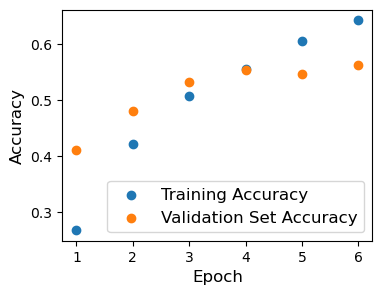

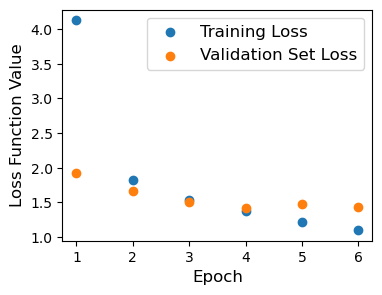

In [28]:
history_dict = history.history
plt.figure(figsize = (4, 3))
plt.scatter(range(1,early_stopping.stopped_epoch+2), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,early_stopping.stopped_epoch+2), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

plt.figure(figsize = (4, 3))

plt.scatter(range(1,early_stopping.stopped_epoch+2), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,early_stopping.stopped_epoch+2), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

# vvv
### Report accuracy on validation set 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


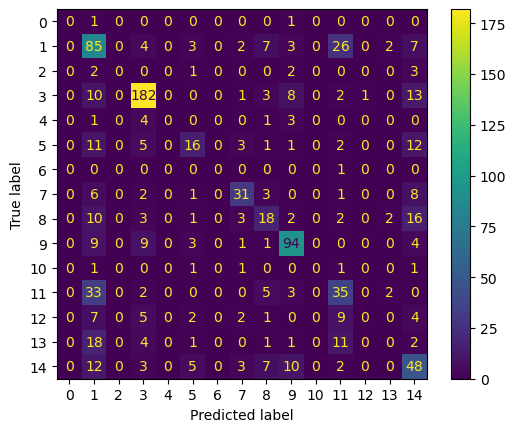

accuracy = 0.5636766334440753


In [31]:
predicted_vector = model_mfcc_c_c_fam.predict(X_val)
predicted_class_index = np.argmax(predicted_vector, axis=-1)
pred_class = le.inverse_transform(predicted_class_index)
true_class_idx = np.where(y_val.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
#print(true_class)
conf_mat = confusion_matrix(true_class, pred_class)
#print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix 
                                            = conf_mat)
cm_display.plot()
plt.show()
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

In [32]:
print(np.unique(true_class))
print(np.unique(pred_class))

['Cicadidae' 'Conocephalinae' 'Eneopterinae' 'Gryllinae' 'Gryllotalpidae'
 'Hapithinae' 'Listroscelidinae' 'Mogoplistinae' 'Nemobiinae'
 'Oecanthinae' 'Phalangopsidae' 'Phaneropterinae' 'Pseudophyllinae'
 'Tettigoniinae' 'Trigonidiinae']
['Conocephalinae' 'Gryllinae' 'Hapithinae' 'Mogoplistinae' 'Nemobiinae'
 'Oecanthinae' 'Phaneropterinae' 'Pseudophyllinae' 'Tettigoniinae'
 'Trigonidiinae']


   0    1    2
0  0    1    1
1  0  538   76
2  0   59  228
accuracy = 0.8482834994462901


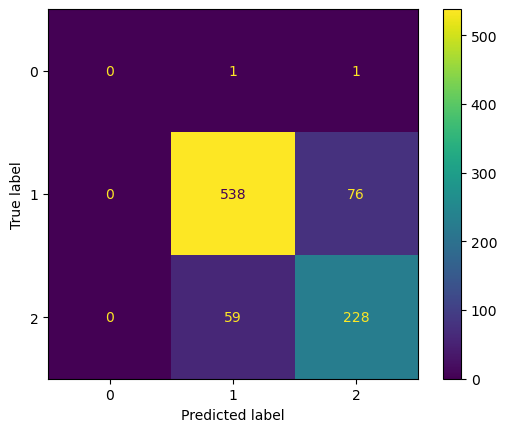

In [33]:
## to shorte list of classes after fitting on long list, use the class converter. 
label_name = 'fam_or_subfam'
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')
conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix 
                                            = conf_mat)
cm_display.plot()
plt.show()

# vvv 
### Forbidden test set block

In [37]:
audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Final_Test.csv'

max_time = 5 # cut off time for loading, in sec
get_feature_function = mfcc_cut_cleaned
test_songs_matrix, test_songs_id = get_data(audio_path, meta_file, max_time, get_feature_function)
test_songs_label_critter = get_labels(test_songs_id, meta_file, 'critter_name')
test_songs_label_fam = get_labels(test_songs_id, meta_file, 'fam_or_subfam')


In [38]:
predicted_vector = model.predict(test_songs_matrix)
predicted_class_index = np.argmax(predicted_vector, axis=-1)

pred_class = le.inverse_transform(predicted_class_index)

#true_class_idx = np.where(test_songs_label_fam.astype(int))[1]
#true_class = le.inverse_transform(true_class_idx)
true_class = test_songs_label_fam
print(true_class)

conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
['Conocephalinae' 'Gryllinae' 'Nemobiinae' ... 'Phaneropterinae'
 'Eneopterinae' 'Hapithinae']
    0    1   2    3   4   5   6   7   8    9   10  11  12  13  14
0    0    6   0    0   0   1   0   0   0    2   0   1   0   0   1
1    0  105   0    3   0   6   0   1   5    7   0  17   0  11   8
2    0    0   0    3   0   3   0   0   0    0   0   0   0   0   0
3    0    3   0  238   1   8   0   4   1   10   0   2   6   3   6
4    0    0   0    2   1   0   0   0   0    4   0   0   1   0   0
5    0    7   0   11   0  38   0   3   2    7   0   1   1   0   5
6    0    0   0    0   0   0   0   0   0    0   0   1   0   1   0
7    0    6   0    4   0   9   0  33   4    2   0   1   0   0   8
8    0    8   0    7   0   7   0   7  17    5   0   0   0   1  18
9    0    7   0    8   0   6   0   0   0  117   0   1   1   0   3
10   0    0   0    0   0   1   0   1   0    0   0   0   0   0   0
11   0   37   0    6   0   2   0   3   2    4   0  51   0   5   3
12   0 

In [39]:
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')

conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

   0    1    2
0  0    4    7
1  0  701   64
2  0   69  285
accuracy = 0.8725663716814159


In [40]:
with open('test_set_mfcc_c_c_twohiddenlayer_64_128_5sec_fam.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([true_class, pred_class], f)

In [ ]:
# Getting back the objects:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    obj0, obj1, obj2 = pickle.load(f)